# Introduction
In this project we are going to analyze 'brain tumor dataset' T1 weighted images dataset from figshare,
<br>
apply some custom functions and Convolutional neural network model that predicts brain tumor type from given image.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Creating neural network model
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2 as cv
import os
from PIL import Image

# I Data preview
#### Step 1 - Image extraction
We're going to convert .mat files to .jpg files. This process basically had me to look at result folder manually to test the conversion by eye.
<br><br>
Preprocessing images:
1) Denoising
2) Exposure
3) Contrast stretching
4) Value scaling

In [8]:
import h5py
from skimage import exposure
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
label_names = ['meningioma', 'glioma', 'pituitary']
matrices = os.listdir(mat_path)

for i, mat in enumerate(matrices):
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0]) - 1
        
        # taking off 'near black' values to reduce background noise
        image = np.array(image)
        image[image <= 80] = 0
        
        # function that fixes exposure
        image = exposure.equalize_hist(image)
            
        # contrast stretching, and value scaling
        image = 255 * (image - (image.min())) / (image.max() - (image.min()))
        
        image = np.array(image).astype(np.uint8)
        img_values = Image.fromarray(image)
        
        file_name = label_names[label] + f"_{i}.png"
        img_values.save(data_path + '\\' + '\\' + label_names[label] + '\\' + file_name)

C:\Users\ati\AppData\Local\Temp\ipykernel_5300\2044667583.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(file['cjdata']['label'][0]) - 1


We only want the image and label. We want to train our model to learn from it by itself.

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=8, color_mode='grayscale', image_size=(256, 256))
label_names = data.class_names
print(f"Labels: {label_names}\n")

Found 3064 files belonging to 3 classes.
Labels: ['glioma', 'meningioma', 'pituitary']



In [10]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

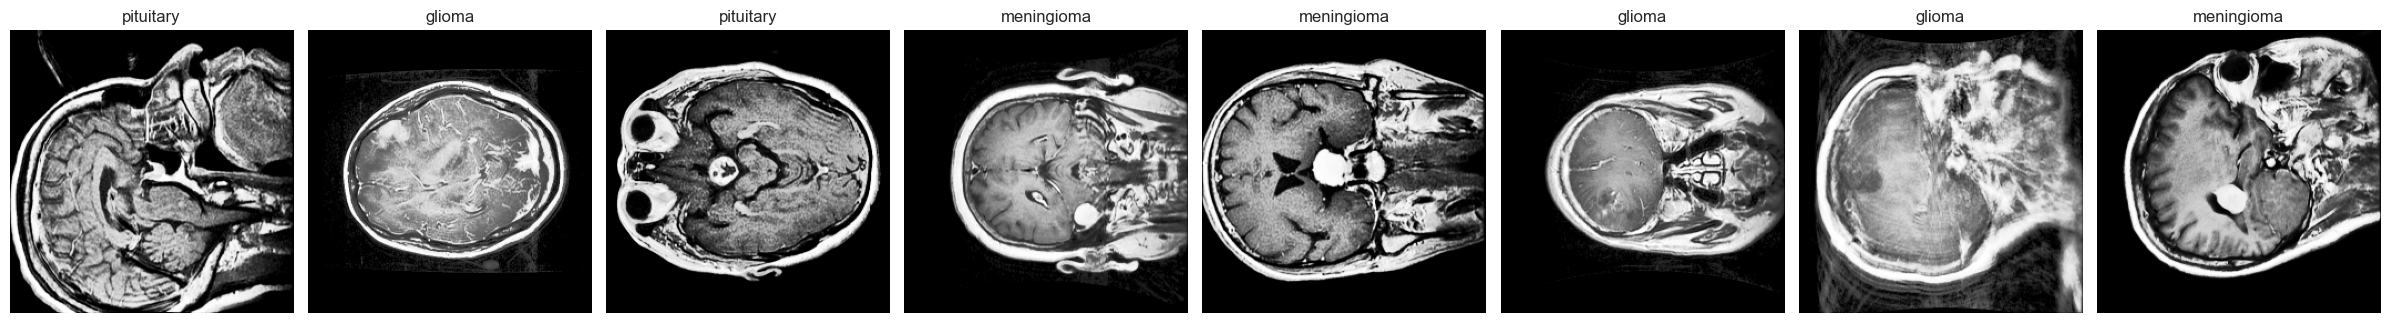

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = label_names[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

    glioma: 1426
meningioma: 708
 pituitary: 930


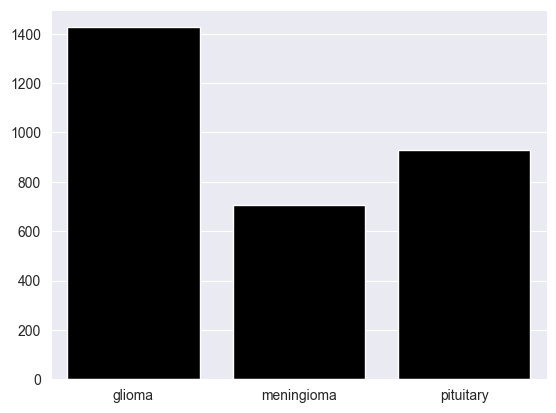

In [12]:
files_per_label = lambda x: os.listdir(data_path + '\\' + x)

labels_len = {label: len(files_per_label(label)) for label in label_names}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color='Black')

for label in label_names:
    print(f"{label:>10}: {len(os.listdir(f"{data_path}\\{label}"))}")
    
plt.show()

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
by using *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.
<br><br>
I tested downsampling by removing random files from glioma and pituitary folders. However it didn't help at all, it even dropped accuracy by almost 10%.

# II Feature scaling
Scaling our values from range (0, 255) to (0, 1) will help our optimization algorithm (Adam).
<br><br>
x = image values
<br> 
y = labels

In [13]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
254.25


In [14]:
data = data.map(lambda x, y: (x/255, y))

In [15]:
iterator = data.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.9970588


Checking black/white balance in images. For selecting reference point on scale I used harmonic mean because it favortise lower values.
<br>
Every point on the plot is a single image, we can see that most of images hang around ratio of 0.19

          Mean: 0.4798709750175476
 Harmonic mean: 0.47953394055366516


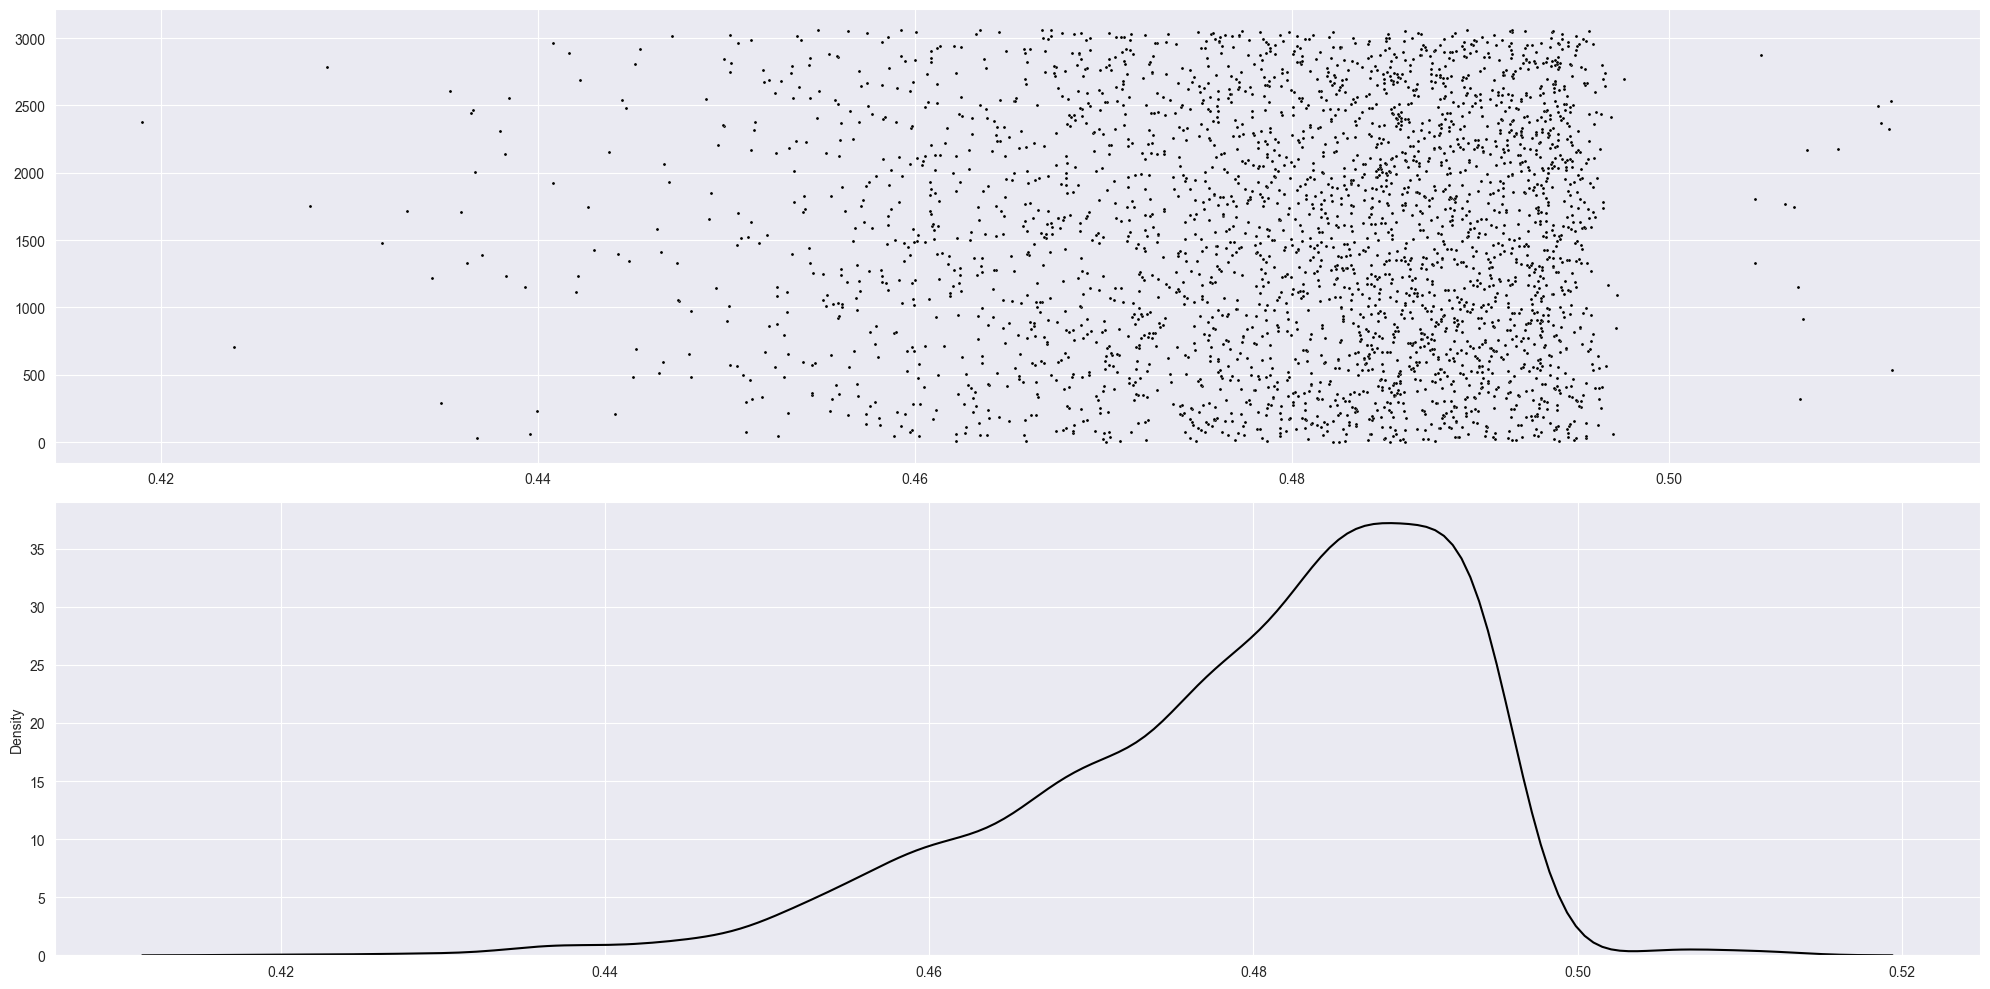

In [16]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)
# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color='black', s=5, ax=axes[0])
sb.kdeplot(x=all_means, color='black', ax=axes[1])
plt.tight_layout()

###### THIS FUNCTION WAS USED IN OLD DATASET WHERE MEAN VALUES WERE SPREAD MORE

In [17]:
def scale_to_target(batch, target=0.5, multiplier=1):
    f"""
    This function scales image values inside given array to achieve mean value that equals target value.\n
    mean of array => target\n
    array - the array to be scaled\n
    target - value that we want our mean of given array to become\n
    multiplier - % of effect, 0.5 is basically mean of our array mean and target value
    """
    def scale_single_image(img):
        current_mean = tf.reduce_mean(img)
        new_mean = current_mean + (multiplier * (target - current_mean))
        scale_factor = new_mean / current_mean if current_mean != 0 else tf.cast(0, dtype=new_mean.dtype)
        return img * scale_factor

    scaled_batch = tf.map_fn(scale_single_image, batch)
    return scaled_batch

# III Creating CNN Model
- In short convolutional neural network base on layers that convolve input matrix (image) through filter matrices resulting filtered output.
<br>
- As input shape we apply values that corresponds to:
    - width = 256
    - height = 256
    - channel = 1 (we use grayscaled images).
<br>
- __*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.
<br>
- Since our dataset contain 4 classes I applied __*softmax*__ activation to last step.

In [18]:
train_batch_size = round(len(data) * 0.7)
val_batch_size = round(len(data) * 0.2)
test_batch_size = round(len(data) * 0.1)

len(data) == train_batch_size + val_batch_size + test_batch_size

True

In [19]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)
test = data.skip(train_batch_size + val_batch_size).take(test_batch_size)

print(
    f"train: {len(train)} batches\nval: {len(val)} batches\ntest: {len(test)} batches"
)

train: 268 batches
val: 77 batches
test: 38 batches


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [21]:
def create_model(num_layers = 1, num_filters = 16, kernel_size = 3, regulate = 0.0001, learning_rate = 0.001):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters*2, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(regulate)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
model = create_model(regulate=0.0001, learning_rate=0.0001)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,108 (14.10 MB)

 Trainable params: 3,697,108 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callback_board = tf.keras.callbacks.TensorBoard('data_processed_imgs')

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[callback_board])

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.5770 - loss: 0.9636 - val_accuracy: 0.7630 - val_loss: 0.5804
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.7477 - loss: 0.5971 - val_accuracy: 0.8214 - val_loss: 0.4942
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.8072 - loss: 0.4792 - val_accuracy: 0.8506 - val_loss: 0.4347
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.8619 - loss: 0.3721 - val_accuracy: 0.8636 - val_loss: 0.3762
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.8825 - loss: 0.3179 - val_accuracy: 0.8782 - val_loss: 0.3242
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.9154 - loss: 0.2567 - val_accuracy: 0.9026 - val_loss: 0.2873
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9189 - loss: 0.2391 - val_accuracy: 0.9058 - val_loss: 0.2741
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9338 - loss: 0.2122 - 

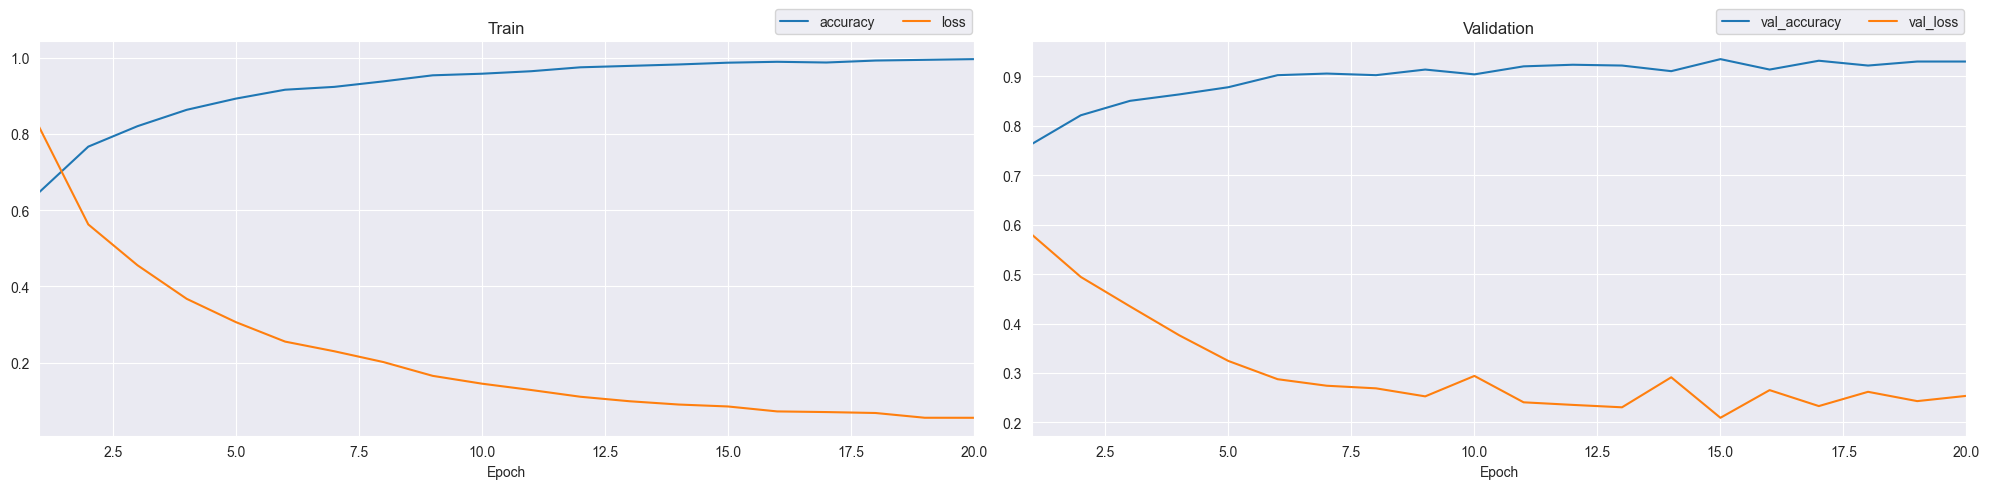

In [29]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(1, 21, 1)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim([1, 20])

axes[1].set_title('Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_xlim([1, 20])

plt.tight_layout()
plt.show()

In [30]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95       135
  meningioma       0.94      0.85      0.89        73
   pituitary       0.97      1.00      0.98        96

    accuracy                           0.95       304
   macro avg       0.95      0.94      0.94       304
weighted avg       0.95      0.95      0.95       304



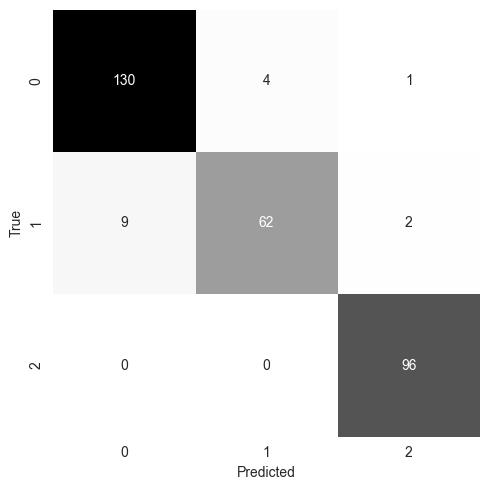

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

In [37]:
with open('unprocessed_imgs_report.txt', 'r') as f:
    for line in f:
        print(line, end='')

              precision    recall  f1-score   support

      glioma       0.84      0.98      0.90       124
  meningioma       0.95      0.74      0.83        77
   pituitary       1.00      0.97      0.99       103

    accuracy                           0.91       304
   macro avg       0.93      0.90      0.91       304
weighted avg       0.92      0.91      0.91       304
